In [235]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

In [236]:
def print_quantum_state_as_superposition(state):
    """
    Helper function to print quantum state as superposition of basis functions.
    """
    state = state.unit()
    dimension = int(np.log2(state.shape[0]))
    state_vector = state.full().flatten()
    basis_states = ['0', '1']
    
    superposition = []
    for i, amplitude in enumerate(state_vector):
        abs_amplitude = np.abs(amplitude)

        if round(abs_amplitude, 2) > 0:
            real_part = amplitude.real
            imag_part = amplitude.imag

            amplitude_str = ""
            if np.isclose(real_part, 0, atol=1e-2) and np.isclose(imag_part, 0, atol=1e-2):
                continue 

            if not np.isclose(real_part, 0, atol=1e-2):
                amplitude_str += f"{real_part:.2f}"
            
            if not np.isclose(imag_part, 0, atol=1e-2):
                if imag_part > 0 and amplitude_str:
                    amplitude_str += f" + {imag_part:.2f}i"
                else:
                    amplitude_str += f" {imag_part:.2f}i"

            binary_state = ''.join(basis_states[int(bit)] for bit in f"{i:0{dimension}b}")
            superposition.append(f"{amplitude_str}|{binary_state}⟩")

    superposition = [i.replace(' ','') for i in superposition]
    superposition_str = ' + '.join(superposition).replace('+-', '-').replace('+ -', '- ')
    
    print(f"|ψ⟩ = {superposition_str}")


def is_stabilized(state, stabilizers):
    """
    Check if a state is stabilized
    """
    stabilized = True
    syndrome = []
    overlaps = []
    for stabilizer in stabilizers:
        overlap = state.overlap(stabilizer * state)
        overlaps.append(np.abs(overlap))
        if not np.real(overlap) > 0.99:
            stabilized = False
            syndrome.append(1)
        else:
            syndrome.append(0)
            
    return syndrome, stabilized, overlaps

Text(0.5, 1.0, 'Pulses over time')

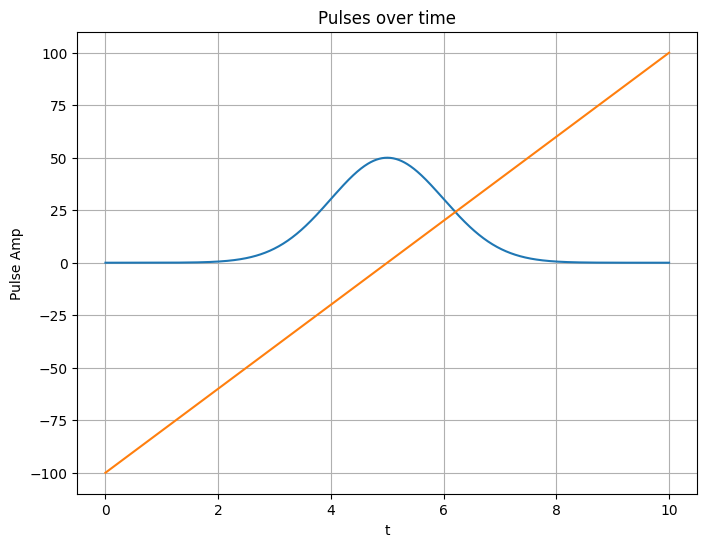

In [245]:
# defining time dependant coefs
T = 10
t = np.linspace(0, T, 1000)
sigma = 1
omega_t = 50 * np.exp(-0.5 * ((t - T/2) / sigma) ** 2)

delta_t = 100*(t / (T/2) - 1)

# Plot the wave
plt.figure(figsize=(8, 6))
plt.plot(t, omega_t)
plt.plot(t, delta_t)
plt.xlabel("t")
plt.ylabel("Pulse Amp")
plt.grid(True)
plt.title("Pulses over time")


In [238]:
I = qeye(2)
X = sigmax()
Y = sigmay()
Z = sigmaz()

# Define the stabilizer generators for the 5-qubit bit-flip code
g1 = tensor(X, X, X, X)
g2 = tensor(Z, Z, Z, Z)
g3 = tensor(X, Y, Z, I)

stabilizers = [
    g1,
    g2,
    g3
]

H_x = tensor(Y, I, Y, I)
H_z = tensor(Z, Z, I, I)

In [263]:
basis_states = [basis(2, 0), basis(2, 1)]

# Define the logical zero state |0_L>
logical_zero = (tensor(basis_states[0], basis_states[0], basis_states[0], basis_states[0]) +
                1j*tensor(basis_states[0], basis_states[0], basis_states[1], basis_states[1]) +
                1j*tensor(basis_states[1], basis_states[1], basis_states[0], basis_states[0]) +
                tensor(basis_states[1], basis_states[1], basis_states[1], basis_states[1])).unit()

logical_X = tensor(Y, I, Y, I)
logical_Y = -tensor(I, X, X, I)
logical_Z = tensor(Z, Z, I, I)


logical_one = logical_X * logical_zero

# Applying error
error = tensor(I, X, I, X)
logical_zero = error * logical_zero
logical_one = error * logical_one

print_quantum_state_as_superposition(logical_zero)
print_quantum_state_as_superposition(logical_one)

result_zero = is_stabilized(logical_zero, stabilizers)
result_one = is_stabilized(logical_one, stabilizers)
print(f"Logical |0_L> is stabilized: {result_zero[1]} and the syndrom is {result_zero[0]}")
print(f"Logical |1_L> is stabilized: {result_one[1]} and the syndrom is {result_one[0]}")

|ψ⟩ = 0.50|0101⟩ + 0.50i|0110⟩ + 0.50i|1001⟩ + 0.50|1010⟩
|ψ⟩ = -0.50|0000⟩ + 0.50i|0011⟩ + 0.50i|1100⟩ - 0.50|1111⟩
Logical |0_L> is stabilized: False and the syndrom is [0, 0, 1]
Logical |1_L> is stabilized: False and the syndrom is [0, 0, 1]


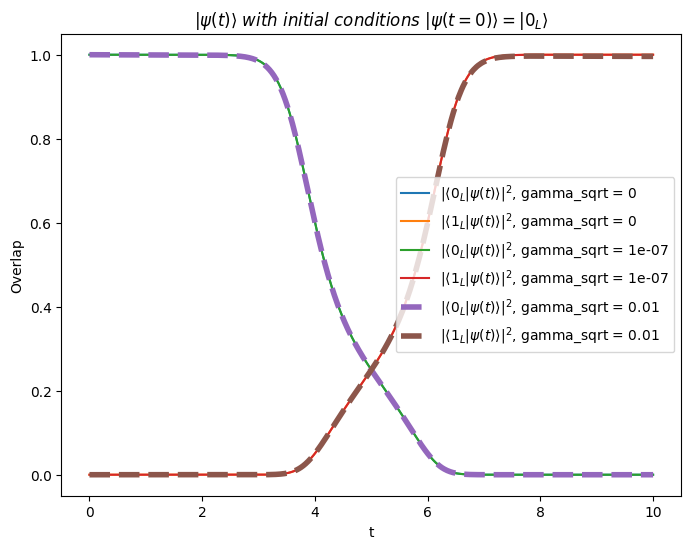

In [274]:
gamma_sqrts = [0, 0.0000001, 0.01]
plt.figure(figsize=(8, 6))

for i, gamma_sqrt in enumerate(gamma_sqrts):
    Ep = 0.1
    Hp = -Ep*(g1 + g2 + g3)

    C_op = gamma_sqrt * sigmam()
    collapse_ops = [
        tensor(C_op, I, I, I),
        tensor(I, C_op, I, I),
        tensor(I, I, C_op, I),
        tensor(I, I, I, C_op)
    ]

    # Define time-dependent Hamiltonian
    H_S = [[H_x, omega_t], [H_z, delta_t], Hp]
    output = mesolve(H_S, logical_zero, t, collapse_ops, [])

    expect_psi_0 = []
    expect_psi_1 = []

    for index, state in enumerate(output.states):
        expect_stat_psi_0 = np.abs(logical_zero.overlap(state))**2
        expect_stat_psi_1 = np.abs(logical_one.overlap(state))**2
        
        expect_psi_0.append(expect_stat_psi_0)
        expect_psi_1.append(expect_stat_psi_1)

    eigenvalues_0 = np.array(expect_psi_0)
    eigenvalues_1 = np.array(expect_psi_1)

    # Plotting the results
    if i == (len(gamma_sqrts) - 1):
        plt.plot(t, eigenvalues_0, '--', label=r'$|\langle 0_L | \psi(t) \rangle|^2$, gamma_sqrt = {}'.format(gamma_sqrt), linewidth=4)
        plt.plot(t, eigenvalues_1, '--', label=r'$|\langle 1_L | \psi(t) \rangle|^2$, gamma_sqrt = {}'.format(gamma_sqrt), linewidth=4)
    else:
        plt.plot(t, eigenvalues_0, label=r'$|\langle 0_L | \psi(t) \rangle|^2$, gamma_sqrt = {}'.format(gamma_sqrt))
        plt.plot(t, eigenvalues_1, label=r'$|\langle 1_L | \psi(t) \rangle|^2$, gamma_sqrt = {}'.format(gamma_sqrt))

plt.legend()
plt.title(r'$| \psi(t) \rangle \ with \ initial \ conditions \ | \psi(t=0) \rangle = |0_L\rangle$')
plt.xlabel("t")
plt.ylabel("Overlap")
plt.show()